Exploring environment

In [1]:
import random
import copy
import os
import imageio
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym


env = gym.make("MountainCar-v0", render_mode="rgb_array")

In [2]:
env.spec

EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_checker=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='MountainCar', version=0, additional_wrappers=(), vector_entry_point=None)

In [3]:
print(env.observation_space)
print(env.observation_space.shape[0])

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
2


In [4]:
print(env.action_space)
print(env.action_space.n)

Discrete(3)
3


In [5]:
print(env.action_space.sample())
print(env.observation_space.sample())

1
[-0.62197864  0.04388507]


In [6]:
obs,info = env.reset()

In [7]:
torch.tensor(obs,dtype=torch.float32).unsqueeze(0).shape

torch.Size([1, 2])

In [8]:
info

{}

In [9]:
total_reward = 0
obs,info = env.reset()
for step in range(1000):
  action = env.action_space.sample()
  obs,reward,terminated,truncated,info=env.step(action)
  total_reward = total_reward + reward
  print(obs,reward,terminated,truncated,step)
  if terminated or truncated:
    break
print(total_reward)

[-4.2052007e-01  2.4089357e-04] -1.0 False False 0
[-0.42204002 -0.00151993] -1.0 False False 1
[-0.4243099 -0.0022699] -1.0 False False 2
[-0.4273135 -0.0030036] -1.0 False False 3
[-0.43002924 -0.00271574] -1.0 False False 4
[-0.43243757 -0.00240833] -1.0 False False 5
[-0.43552113 -0.00308355] -1.0 False False 6
[-0.4392576  -0.00373647] -1.0 False False 7
[-0.44361988 -0.0043623 ] -1.0 False False 8
[-0.4485763 -0.0049564] -1.0 False False 9
[-0.4550906  -0.00651433] -1.0 False False 10
[-0.46311516 -0.00802454] -1.0 False False 11
[-0.47259083 -0.00947568] -1.0 False False 12
[-0.48344758 -0.01085674] -1.0 False False 13
[-0.49460474 -0.01115715] -1.0 False False 14
[-0.5049791  -0.01037433] -1.0 False False 15
[-0.515493   -0.01051391] -1.0 False False 16
[-0.5250677 -0.0095747] -1.0 False False 17
[-0.53563136 -0.01056368] -1.0 False False 18
[-0.5471048  -0.01147345] -1.0 False False 19
[-0.5584021  -0.01129731] -1.0 False False 20
[-0.57043886 -0.01203675] -1.0 False False 21


Training Double DQN

In [10]:

class Q_Network(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size,hidden_size)
    self.fc2 = nn.Linear(hidden_size,hidden_size)
    self.fc3 = nn.Linear(hidden_size,output_size)

  def forward(self,x):
    x = self.fc1(x)
    x = nn.ReLU()(x)
    x = self.fc2(x)
    x= nn.ReLU()(x)
    x = self.fc3(x)
    return x


In [11]:


class ReplayBuffer():
  def __init__(self,capacity,device):
    self.buffer = deque(maxlen=capacity)
    self.device = device

  def add(self,state,action,reward,next_state,done):
    self.buffer.append((state,action,reward,next_state,done))


  def sample(self,batch_size):
    batch = random.sample(self.buffer,batch_size)
    states,actions,rewards,next_states,dones = zip(*batch)

    return (
        torch.tensor(states,dtype=torch.float32,device=self.device),
        torch.tensor(actions,dtype=torch.int32,device=self.device),
        torch.tensor(rewards,dtype=torch.float32,device=self.device),
        torch.tensor(next_states,dtype=torch.float32,device=self.device),
        torch.tensor(dones,dtype=torch.float32,device=self.device)
    )

  def len(self):
    return len(self.buffer)



In [12]:
os.makedirs("results", exist_ok=True)
MODEL_DIR = "./results/models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, "dqn_model.pt")


def evaluate_and_record(env, q_net, device, max_steps=1000):
    q_net.eval()
    frames = []
    state, _ = env.reset()
    total_reward = 0

    for _ in range(max_steps):
        frame = env.render()
        if frame is not None:
            frames.append(frame)

        with torch.no_grad():
            q_vals = q_net(
                torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            )
            action = torch.argmax(q_vals).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    q_net.train()
    frames = np.array(frames)
    print(f"Evaluation Reward: {total_reward:7.2f}")
    return total_reward, frames


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q_net = Q_Network(
    input_size=env.observation_space.shape[0],
    hidden_size=64,
    output_size=env.action_space.n,
).to(device)

target_q_net = copy.deepcopy(q_net).to(device)
target_q_net.eval()

optimizer = optim.Adam(q_net.parameters(), lr=5e-4)
loss_fn = nn.SmoothL1Loss()

buffer = ReplayBuffer(capacity=50_000, device=device)

num_episodes = 2000
batch_size = 32
gamma = 0.99

epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.999

eval_every = 100
tau = 0.005

reward_list = []
epsilon_list = []
eval_rewards = []

SOLVED_REWARD = -110
SOLVED_WINDOW = 50

for eps in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0

    for step in range(200):
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_vals = q_net(
                    torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                )
                action = torch.argmax(q_vals).item()

        next_state, reward, terminated, truncated, _ = env.step(action)

        #shaped_reward = reward + 10 * abs(next_state[1])  # Reward shaping (encourage velocity). Agent does not train without this.
        buffer.add(state, action, reward, next_state, terminated or truncated)
        state = next_state
        total_reward += reward

        if buffer.len() >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            with torch.no_grad():
                next_actions = torch.argmax(q_net(next_states), dim=1)
                next_q = target_q_net(next_states).gather(
                    1, next_actions.unsqueeze(1)
                ).squeeze(1)
                targets = rewards + gamma * next_q * (1 - dones)

            q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            loss = loss_fn(q_values, targets)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(q_net.parameters(), max_norm=10.0)
            optimizer.step()

            for target_param, param in zip(target_q_net.parameters(), q_net.parameters()):
                target_param.data.copy_(
                    tau * param.data + (1 - tau) * target_param.data
                )

        if terminated or truncated:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    reward_list.append(total_reward)
    epsilon_list.append(epsilon)

    print(f"Episode {eps:4d} | Reward: {total_reward:7.2f} | Epsilon: {epsilon:.3f}")

    if len(reward_list) >= SOLVED_WINDOW:
        avg_reward = np.mean(reward_list[-SOLVED_WINDOW:])
        if avg_reward >= SOLVED_REWARD:
            print(f"SOLVED at episode {eps}")
            torch.save(
                {
                    "episode": eps,
                    "model_state_dict": q_net.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "epsilon": epsilon,
                    "avg_reward_100": avg_reward,
                },
                MODEL_PATH,
            )
            break

    if eps % eval_every == 0:
        eval_reward, frames = evaluate_and_record(env, q_net, device)
        eval_rewards.append(eval_reward)

        video_path = f"./results/eval_ep{eps}.mp4"
        imageio.mimsave(video_path, frames, fps=30)

env.close()


/tmp/ipython-input-3246115743.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  torch.tensor(states,dtype=torch.float32,device=self.device),


Episode    0 | Reward: -200.00 | Epsilon: 0.999
Evaluation Reward: -200.00


Episode    1 | Reward: -200.00 | Epsilon: 0.998
Episode    2 | Reward: -200.00 | Epsilon: 0.997
Episode    3 | Reward: -200.00 | Epsilon: 0.996
Episode    4 | Reward: -200.00 | Epsilon: 0.995
Episode    5 | Reward: -200.00 | Epsilon: 0.994
Episode    6 | Reward: -200.00 | Epsilon: 0.993
Episode    7 | Reward: -200.00 | Epsilon: 0.992
Episode    8 | Reward: -200.00 | Epsilon: 0.991
Episode    9 | Reward: -200.00 | Epsilon: 0.990
Episode   10 | Reward: -200.00 | Epsilon: 0.989
Episode   11 | Reward: -200.00 | Epsilon: 0.988
Episode   12 | Reward: -200.00 | Epsilon: 0.987
Episode   13 | Reward: -200.00 | Epsilon: 0.986
Episode   14 | Reward: -200.00 | Epsilon: 0.985
Episode   15 | Reward: -200.00 | Epsilon: 0.984
Episode   16 | Reward: -200.00 | Epsilon: 0.983
Episode   17 | Reward: -200.00 | Epsilon: 0.982
Episode   18 | Reward: -200.00 | Epsilon: 0.981
Episode   19 | Reward: -200.00 | Epsilon: 0.980
Episode   20 | Reward: -200.00 | Epsilon: 0.979
Episode   21 | Reward: -200.00 | Epsilon

Evaluation Reward: -200.00
Episode  101 | Reward: -200.00 | Epsilon: 0.903
Episode  102 | Reward: -200.00 | Epsilon: 0.902
Episode  103 | Reward: -200.00 | Epsilon: 0.901
Episode  104 | Reward: -200.00 | Epsilon: 0.900
Episode  105 | Reward: -200.00 | Epsilon: 0.899
Episode  106 | Reward: -200.00 | Epsilon: 0.898
Episode  107 | Reward: -200.00 | Epsilon: 0.898
Episode  108 | Reward: -200.00 | Epsilon: 0.897
Episode  109 | Reward: -200.00 | Epsilon: 0.896
Episode  110 | Reward: -200.00 | Epsilon: 0.895
Episode  111 | Reward: -200.00 | Epsilon: 0.894
Episode  112 | Reward: -200.00 | Epsilon: 0.893
Episode  113 | Reward: -200.00 | Epsilon: 0.892
Episode  114 | Reward: -200.00 | Epsilon: 0.891
Episode  115 | Reward: -200.00 | Epsilon: 0.890
Episode  116 | Reward: -200.00 | Epsilon: 0.890
Episode  117 | Reward: -200.00 | Epsilon: 0.889
Episode  118 | Reward: -200.00 | Epsilon: 0.888
Episode  119 | Reward: -200.00 | Epsilon: 0.887
Episode  120 | Reward: -200.00 | Epsilon: 0.886
Episode  121 

Evaluation Reward: -200.00
Episode  201 | Reward: -200.00 | Epsilon: 0.817
Episode  202 | Reward: -200.00 | Epsilon: 0.816
Episode  203 | Reward: -200.00 | Epsilon: 0.815
Episode  204 | Reward: -200.00 | Epsilon: 0.815
Episode  205 | Reward: -200.00 | Epsilon: 0.814
Episode  206 | Reward: -200.00 | Epsilon: 0.813
Episode  207 | Reward: -200.00 | Epsilon: 0.812
Episode  208 | Reward: -200.00 | Epsilon: 0.811
Episode  209 | Reward: -200.00 | Epsilon: 0.810
Episode  210 | Reward: -200.00 | Epsilon: 0.810
Episode  211 | Reward: -200.00 | Epsilon: 0.809
Episode  212 | Reward: -200.00 | Epsilon: 0.808
Episode  213 | Reward: -200.00 | Epsilon: 0.807
Episode  214 | Reward: -200.00 | Epsilon: 0.806
Episode  215 | Reward: -200.00 | Epsilon: 0.806
Episode  216 | Reward: -200.00 | Epsilon: 0.805
Episode  217 | Reward: -200.00 | Epsilon: 0.804
Episode  218 | Reward: -200.00 | Epsilon: 0.803
Episode  219 | Reward: -200.00 | Epsilon: 0.802
Episode  220 | Reward: -200.00 | Epsilon: 0.802
Episode  221 

Evaluation Reward: -200.00
Episode  301 | Reward: -200.00 | Epsilon: 0.739
Episode  302 | Reward: -200.00 | Epsilon: 0.738
Episode  303 | Reward: -200.00 | Epsilon: 0.738
Episode  304 | Reward: -200.00 | Epsilon: 0.737
Episode  305 | Reward: -200.00 | Epsilon: 0.736
Episode  306 | Reward: -200.00 | Epsilon: 0.736
Episode  307 | Reward: -200.00 | Epsilon: 0.735
Episode  308 | Reward: -200.00 | Epsilon: 0.734
Episode  309 | Reward: -200.00 | Epsilon: 0.733
Episode  310 | Reward: -200.00 | Epsilon: 0.733
Episode  311 | Reward: -200.00 | Epsilon: 0.732
Episode  312 | Reward: -200.00 | Epsilon: 0.731
Episode  313 | Reward: -200.00 | Epsilon: 0.730
Episode  314 | Reward: -200.00 | Epsilon: 0.730
Episode  315 | Reward: -200.00 | Epsilon: 0.729
Episode  316 | Reward: -200.00 | Epsilon: 0.728
Episode  317 | Reward: -200.00 | Epsilon: 0.727
Episode  318 | Reward: -200.00 | Epsilon: 0.727
Episode  319 | Reward: -200.00 | Epsilon: 0.726
Episode  320 | Reward: -200.00 | Epsilon: 0.725
Episode  321 

Evaluation Reward: -200.00
Episode  401 | Reward: -200.00 | Epsilon: 0.669
Episode  402 | Reward: -200.00 | Epsilon: 0.668
Episode  403 | Reward: -200.00 | Epsilon: 0.668
Episode  404 | Reward: -200.00 | Epsilon: 0.667
Episode  405 | Reward: -200.00 | Epsilon: 0.666
Episode  406 | Reward: -200.00 | Epsilon: 0.666
Episode  407 | Reward: -200.00 | Epsilon: 0.665
Episode  408 | Reward: -200.00 | Epsilon: 0.664
Episode  409 | Reward: -200.00 | Epsilon: 0.664
Episode  410 | Reward: -200.00 | Epsilon: 0.663
Episode  411 | Reward: -200.00 | Epsilon: 0.662
Episode  412 | Reward: -200.00 | Epsilon: 0.662
Episode  413 | Reward: -200.00 | Epsilon: 0.661
Episode  414 | Reward: -200.00 | Epsilon: 0.660
Episode  415 | Reward: -200.00 | Epsilon: 0.660
Episode  416 | Reward: -200.00 | Epsilon: 0.659
Episode  417 | Reward: -200.00 | Epsilon: 0.658
Episode  418 | Reward: -200.00 | Epsilon: 0.658
Episode  419 | Reward: -200.00 | Epsilon: 0.657
Episode  420 | Reward: -200.00 | Epsilon: 0.656
Episode  421 

Evaluation Reward: -200.00
Episode  501 | Reward: -200.00 | Epsilon: 0.605
Episode  502 | Reward: -200.00 | Epsilon: 0.605
Episode  503 | Reward: -200.00 | Epsilon: 0.604
Episode  504 | Reward: -200.00 | Epsilon: 0.603
Episode  505 | Reward: -200.00 | Epsilon: 0.603
Episode  506 | Reward: -200.00 | Epsilon: 0.602
Episode  507 | Reward: -200.00 | Epsilon: 0.602
Episode  508 | Reward: -200.00 | Epsilon: 0.601
Episode  509 | Reward: -200.00 | Epsilon: 0.600
Episode  510 | Reward: -200.00 | Epsilon: 0.600
Episode  511 | Reward: -200.00 | Epsilon: 0.599
Episode  512 | Reward: -200.00 | Epsilon: 0.599
Episode  513 | Reward: -200.00 | Epsilon: 0.598
Episode  514 | Reward: -200.00 | Epsilon: 0.597
Episode  515 | Reward: -200.00 | Epsilon: 0.597
Episode  516 | Reward: -200.00 | Epsilon: 0.596
Episode  517 | Reward: -200.00 | Epsilon: 0.596
Episode  518 | Reward: -200.00 | Epsilon: 0.595
Episode  519 | Reward: -200.00 | Epsilon: 0.594
Episode  520 | Reward: -200.00 | Epsilon: 0.594
Episode  521 

Evaluation Reward: -200.00
Episode  601 | Reward: -200.00 | Epsilon: 0.548
Episode  602 | Reward: -200.00 | Epsilon: 0.547
Episode  603 | Reward: -200.00 | Epsilon: 0.546
Episode  604 | Reward: -200.00 | Epsilon: 0.546
Episode  605 | Reward: -200.00 | Epsilon: 0.545
Episode  606 | Reward: -200.00 | Epsilon: 0.545
Episode  607 | Reward: -200.00 | Epsilon: 0.544
Episode  608 | Reward: -200.00 | Epsilon: 0.544
Episode  609 | Reward: -200.00 | Epsilon: 0.543
Episode  610 | Reward: -200.00 | Epsilon: 0.543
Episode  611 | Reward: -200.00 | Epsilon: 0.542
Episode  612 | Reward: -200.00 | Epsilon: 0.542
Episode  613 | Reward: -200.00 | Epsilon: 0.541
Episode  614 | Reward: -200.00 | Epsilon: 0.540
Episode  615 | Reward: -200.00 | Epsilon: 0.540
Episode  616 | Reward: -200.00 | Epsilon: 0.539
Episode  617 | Reward: -200.00 | Epsilon: 0.539
Episode  618 | Reward: -200.00 | Epsilon: 0.538
Episode  619 | Reward: -200.00 | Epsilon: 0.538
Episode  620 | Reward: -200.00 | Epsilon: 0.537
Episode  621 

Evaluation Reward: -200.00
Episode  701 | Reward: -200.00 | Epsilon: 0.495
Episode  702 | Reward: -200.00 | Epsilon: 0.495
Episode  703 | Reward: -200.00 | Epsilon: 0.494
Episode  704 | Reward: -200.00 | Epsilon: 0.494
Episode  705 | Reward: -200.00 | Epsilon: 0.493
Episode  706 | Reward: -200.00 | Epsilon: 0.493
Episode  707 | Reward: -200.00 | Epsilon: 0.492
Episode  708 | Reward: -200.00 | Epsilon: 0.492
Episode  709 | Reward: -200.00 | Epsilon: 0.491
Episode  710 | Reward: -200.00 | Epsilon: 0.491
Episode  711 | Reward: -200.00 | Epsilon: 0.490
Episode  712 | Reward: -200.00 | Epsilon: 0.490
Episode  713 | Reward: -200.00 | Epsilon: 0.490
Episode  714 | Reward: -200.00 | Epsilon: 0.489
Episode  715 | Reward: -200.00 | Epsilon: 0.489
Episode  716 | Reward: -200.00 | Epsilon: 0.488
Episode  717 | Reward: -200.00 | Epsilon: 0.488
Episode  718 | Reward: -200.00 | Epsilon: 0.487
Episode  719 | Reward: -200.00 | Epsilon: 0.487
Episode  720 | Reward: -200.00 | Epsilon: 0.486
Episode  721 

Evaluation Reward: -200.00
Episode  801 | Reward: -200.00 | Epsilon: 0.448
Episode  802 | Reward: -200.00 | Epsilon: 0.448
Episode  803 | Reward: -200.00 | Epsilon: 0.447
Episode  804 | Reward: -200.00 | Epsilon: 0.447
Episode  805 | Reward: -200.00 | Epsilon: 0.446
Episode  806 | Reward: -200.00 | Epsilon: 0.446
Episode  807 | Reward: -200.00 | Epsilon: 0.446
Episode  808 | Reward: -200.00 | Epsilon: 0.445
Episode  809 | Reward: -200.00 | Epsilon: 0.445
Episode  810 | Reward: -200.00 | Epsilon: 0.444
Episode  811 | Reward: -200.00 | Epsilon: 0.444
Episode  812 | Reward: -200.00 | Epsilon: 0.443
Episode  813 | Reward: -200.00 | Epsilon: 0.443
Episode  814 | Reward: -200.00 | Epsilon: 0.442
Episode  815 | Reward: -200.00 | Epsilon: 0.442
Episode  816 | Reward: -200.00 | Epsilon: 0.442
Episode  817 | Reward: -200.00 | Epsilon: 0.441
Episode  818 | Reward: -200.00 | Epsilon: 0.441
Episode  819 | Reward: -200.00 | Epsilon: 0.440
Episode  820 | Reward: -200.00 | Epsilon: 0.440
Episode  821 

Evaluation Reward: -200.00
Episode  901 | Reward: -200.00 | Epsilon: 0.406
Episode  902 | Reward: -200.00 | Epsilon: 0.405
Episode  903 | Reward: -200.00 | Epsilon: 0.405
Episode  904 | Reward: -200.00 | Epsilon: 0.404
Episode  905 | Reward: -200.00 | Epsilon: 0.404
Episode  906 | Reward: -200.00 | Epsilon: 0.404
Episode  907 | Reward: -200.00 | Epsilon: 0.403
Episode  908 | Reward: -200.00 | Epsilon: 0.403
Episode  909 | Reward: -200.00 | Epsilon: 0.402
Episode  910 | Reward: -200.00 | Epsilon: 0.402
Episode  911 | Reward: -200.00 | Epsilon: 0.402
Episode  912 | Reward: -200.00 | Epsilon: 0.401
Episode  913 | Reward: -200.00 | Epsilon: 0.401
Episode  914 | Reward: -200.00 | Epsilon: 0.400
Episode  915 | Reward: -200.00 | Epsilon: 0.400
Episode  916 | Reward: -200.00 | Epsilon: 0.400
Episode  917 | Reward: -200.00 | Epsilon: 0.399
Episode  918 | Reward: -200.00 | Epsilon: 0.399
Episode  919 | Reward: -200.00 | Epsilon: 0.398
Episode  920 | Reward: -200.00 | Epsilon: 0.398
Episode  921 

Evaluation Reward: -200.00
Episode 1001 | Reward: -200.00 | Epsilon: 0.367
Episode 1002 | Reward: -200.00 | Epsilon: 0.367
Episode 1003 | Reward: -200.00 | Epsilon: 0.366
Episode 1004 | Reward: -200.00 | Epsilon: 0.366
Episode 1005 | Reward: -200.00 | Epsilon: 0.365
Episode 1006 | Reward: -200.00 | Epsilon: 0.365
Episode 1007 | Reward: -200.00 | Epsilon: 0.365
Episode 1008 | Reward: -200.00 | Epsilon: 0.364
Episode 1009 | Reward: -200.00 | Epsilon: 0.364
Episode 1010 | Reward: -200.00 | Epsilon: 0.364
Episode 1011 | Reward: -200.00 | Epsilon: 0.363
Episode 1012 | Reward: -200.00 | Epsilon: 0.363
Episode 1013 | Reward: -200.00 | Epsilon: 0.363
Episode 1014 | Reward: -200.00 | Epsilon: 0.362
Episode 1015 | Reward: -200.00 | Epsilon: 0.362
Episode 1016 | Reward: -200.00 | Epsilon: 0.361
Episode 1017 | Reward: -200.00 | Epsilon: 0.361
Episode 1018 | Reward: -200.00 | Epsilon: 0.361
Episode 1019 | Reward: -200.00 | Epsilon: 0.360
Episode 1020 | Reward: -200.00 | Epsilon: 0.360
Episode 1021 

Evaluation Reward: -157.00
Episode 1101 | Reward: -169.00 | Epsilon: 0.332
Episode 1102 | Reward: -200.00 | Epsilon: 0.332
Episode 1103 | Reward: -163.00 | Epsilon: 0.331
Episode 1104 | Reward: -200.00 | Epsilon: 0.331
Episode 1105 | Reward: -200.00 | Epsilon: 0.331
Episode 1106 | Reward: -167.00 | Epsilon: 0.330
Episode 1107 | Reward: -200.00 | Epsilon: 0.330
Episode 1108 | Reward: -200.00 | Epsilon: 0.330
Episode 1109 | Reward: -200.00 | Epsilon: 0.329
Episode 1110 | Reward: -200.00 | Epsilon: 0.329
Episode 1111 | Reward: -200.00 | Epsilon: 0.329
Episode 1112 | Reward: -200.00 | Epsilon: 0.328
Episode 1113 | Reward: -200.00 | Epsilon: 0.328
Episode 1114 | Reward: -163.00 | Epsilon: 0.328
Episode 1115 | Reward: -154.00 | Epsilon: 0.327
Episode 1116 | Reward: -157.00 | Epsilon: 0.327
Episode 1117 | Reward: -200.00 | Epsilon: 0.327
Episode 1118 | Reward: -200.00 | Epsilon: 0.326
Episode 1119 | Reward: -200.00 | Epsilon: 0.326
Episode 1120 | Reward: -200.00 | Epsilon: 0.326
Episode 1121 

Evaluation Reward:  -86.00
Episode 1201 | Reward: -200.00 | Epsilon: 0.300
Episode 1202 | Reward: -200.00 | Epsilon: 0.300
Episode 1203 | Reward: -159.00 | Epsilon: 0.300
Episode 1204 | Reward: -152.00 | Epsilon: 0.300
Episode 1205 | Reward: -200.00 | Epsilon: 0.299
Episode 1206 | Reward: -200.00 | Epsilon: 0.299
Episode 1207 | Reward: -166.00 | Epsilon: 0.299
Episode 1208 | Reward: -200.00 | Epsilon: 0.298
Episode 1209 | Reward: -152.00 | Epsilon: 0.298
Episode 1210 | Reward: -156.00 | Epsilon: 0.298
Episode 1211 | Reward: -158.00 | Epsilon: 0.297
Episode 1212 | Reward: -200.00 | Epsilon: 0.297
Episode 1213 | Reward: -200.00 | Epsilon: 0.297
Episode 1214 | Reward: -149.00 | Epsilon: 0.297
Episode 1215 | Reward: -200.00 | Epsilon: 0.296
Episode 1216 | Reward: -158.00 | Epsilon: 0.296
Episode 1217 | Reward: -162.00 | Epsilon: 0.296
Episode 1218 | Reward: -169.00 | Epsilon: 0.295
Episode 1219 | Reward: -147.00 | Epsilon: 0.295
Episode 1220 | Reward: -150.00 | Epsilon: 0.295
Episode 1221 

Evaluation Reward:  -94.00
Episode 1301 | Reward: -159.00 | Epsilon: 0.272
Episode 1302 | Reward: -149.00 | Epsilon: 0.272
Episode 1303 | Reward: -151.00 | Epsilon: 0.271
Episode 1304 | Reward: -148.00 | Epsilon: 0.271
Episode 1305 | Reward: -158.00 | Epsilon: 0.271
Episode 1306 | Reward: -145.00 | Epsilon: 0.270
Episode 1307 | Reward: -162.00 | Epsilon: 0.270
Episode 1308 | Reward: -151.00 | Epsilon: 0.270
Episode 1309 | Reward: -152.00 | Epsilon: 0.270
Episode 1310 | Reward: -153.00 | Epsilon: 0.269
Episode 1311 | Reward: -152.00 | Epsilon: 0.269
Episode 1312 | Reward: -160.00 | Epsilon: 0.269
Episode 1313 | Reward: -148.00 | Epsilon: 0.269
Episode 1314 | Reward: -151.00 | Epsilon: 0.268
Episode 1315 | Reward: -148.00 | Epsilon: 0.268
Episode 1316 | Reward: -156.00 | Epsilon: 0.268
Episode 1317 | Reward: -151.00 | Epsilon: 0.267
Episode 1318 | Reward: -155.00 | Epsilon: 0.267
Episode 1319 | Reward: -150.00 | Epsilon: 0.267
Episode 1320 | Reward: -200.00 | Epsilon: 0.267
Episode 1321 

Evaluation Reward:  -97.00
Episode 1401 | Reward: -156.00 | Epsilon: 0.246
Episode 1402 | Reward: -200.00 | Epsilon: 0.246
Episode 1403 | Reward: -143.00 | Epsilon: 0.245
Episode 1404 | Reward: -159.00 | Epsilon: 0.245
Episode 1405 | Reward: -150.00 | Epsilon: 0.245
Episode 1406 | Reward: -156.00 | Epsilon: 0.245
Episode 1407 | Reward: -148.00 | Epsilon: 0.244
Episode 1408 | Reward: -150.00 | Epsilon: 0.244
Episode 1409 | Reward: -152.00 | Epsilon: 0.244
Episode 1410 | Reward:  -91.00 | Epsilon: 0.244
Episode 1411 | Reward: -149.00 | Epsilon: 0.243
Episode 1412 | Reward: -157.00 | Epsilon: 0.243
Episode 1413 | Reward: -200.00 | Epsilon: 0.243
Episode 1414 | Reward: -140.00 | Epsilon: 0.243
Episode 1415 | Reward: -151.00 | Epsilon: 0.243
Episode 1416 | Reward: -161.00 | Epsilon: 0.242
Episode 1417 | Reward: -139.00 | Epsilon: 0.242
Episode 1418 | Reward: -200.00 | Epsilon: 0.242
Episode 1419 | Reward: -150.00 | Epsilon: 0.242
Episode 1420 | Reward: -150.00 | Epsilon: 0.241
Episode 1421 

Evaluation Reward: -200.00
Episode 1501 | Reward: -179.00 | Epsilon: 0.223
Episode 1502 | Reward: -139.00 | Epsilon: 0.222
Episode 1503 | Reward: -200.00 | Epsilon: 0.222
Episode 1504 | Reward: -150.00 | Epsilon: 0.222
Episode 1505 | Reward: -151.00 | Epsilon: 0.222
Episode 1506 | Reward: -200.00 | Epsilon: 0.221
Episode 1507 | Reward: -149.00 | Epsilon: 0.221
Episode 1508 | Reward: -200.00 | Epsilon: 0.221
Episode 1509 | Reward: -200.00 | Epsilon: 0.221
Episode 1510 | Reward: -200.00 | Epsilon: 0.221
Episode 1511 | Reward: -150.00 | Epsilon: 0.220
Episode 1512 | Reward: -167.00 | Epsilon: 0.220
Episode 1513 | Reward: -150.00 | Epsilon: 0.220
Episode 1514 | Reward: -200.00 | Epsilon: 0.220
Episode 1515 | Reward: -200.00 | Epsilon: 0.219
Episode 1516 | Reward: -200.00 | Epsilon: 0.219
Episode 1517 | Reward: -200.00 | Epsilon: 0.219
Episode 1518 | Reward: -200.00 | Epsilon: 0.219
Episode 1519 | Reward: -149.00 | Epsilon: 0.219
Episode 1520 | Reward: -147.00 | Epsilon: 0.218
Episode 1521 

Evaluation Reward: -150.00
Episode 1601 | Reward: -157.00 | Epsilon: 0.201
Episode 1602 | Reward: -154.00 | Epsilon: 0.201
Episode 1603 | Reward: -200.00 | Epsilon: 0.201
Episode 1604 | Reward: -160.00 | Epsilon: 0.201
Episode 1605 | Reward: -200.00 | Epsilon: 0.201
Episode 1606 | Reward: -151.00 | Epsilon: 0.200
Episode 1607 | Reward: -153.00 | Epsilon: 0.200
Episode 1608 | Reward: -159.00 | Epsilon: 0.200
Episode 1609 | Reward: -159.00 | Epsilon: 0.200
Episode 1610 | Reward: -200.00 | Epsilon: 0.200
Episode 1611 | Reward: -200.00 | Epsilon: 0.199
Episode 1612 | Reward: -155.00 | Epsilon: 0.199
Episode 1613 | Reward: -189.00 | Epsilon: 0.199
Episode 1614 | Reward: -150.00 | Epsilon: 0.199
Episode 1615 | Reward: -156.00 | Epsilon: 0.199
Episode 1616 | Reward: -200.00 | Epsilon: 0.198
Episode 1617 | Reward: -200.00 | Epsilon: 0.198
Episode 1618 | Reward: -160.00 | Epsilon: 0.198
Episode 1619 | Reward: -157.00 | Epsilon: 0.198
Episode 1620 | Reward: -200.00 | Epsilon: 0.198
Episode 1621 

Evaluation Reward: -141.00
Episode 1701 | Reward: -145.00 | Epsilon: 0.182
Episode 1702 | Reward: -152.00 | Epsilon: 0.182
Episode 1703 | Reward: -158.00 | Epsilon: 0.182
Episode 1704 | Reward: -146.00 | Epsilon: 0.182
Episode 1705 | Reward: -151.00 | Epsilon: 0.181
Episode 1706 | Reward: -152.00 | Epsilon: 0.181
Episode 1707 | Reward: -200.00 | Epsilon: 0.181
Episode 1708 | Reward: -146.00 | Epsilon: 0.181
Episode 1709 | Reward: -161.00 | Epsilon: 0.181
Episode 1710 | Reward: -145.00 | Epsilon: 0.181
Episode 1711 | Reward: -165.00 | Epsilon: 0.180
Episode 1712 | Reward: -150.00 | Epsilon: 0.180
Episode 1713 | Reward: -200.00 | Epsilon: 0.180
Episode 1714 | Reward: -151.00 | Epsilon: 0.180
Episode 1715 | Reward: -200.00 | Epsilon: 0.180
Episode 1716 | Reward: -140.00 | Epsilon: 0.179
Episode 1717 | Reward: -151.00 | Epsilon: 0.179
Episode 1718 | Reward: -200.00 | Epsilon: 0.179
Episode 1719 | Reward: -144.00 | Epsilon: 0.179
Episode 1720 | Reward: -168.00 | Epsilon: 0.179
Episode 1721 

Evaluation Reward:  -92.00
Episode 1801 | Reward: -147.00 | Epsilon: 0.165
Episode 1802 | Reward: -155.00 | Epsilon: 0.165
Episode 1803 | Reward: -149.00 | Epsilon: 0.164
Episode 1804 | Reward: -144.00 | Epsilon: 0.164
Episode 1805 | Reward: -147.00 | Epsilon: 0.164
Episode 1806 | Reward: -166.00 | Epsilon: 0.164
Episode 1807 | Reward: -160.00 | Epsilon: 0.164
Episode 1808 | Reward: -149.00 | Epsilon: 0.164
Episode 1809 | Reward: -150.00 | Epsilon: 0.164
Episode 1810 | Reward: -161.00 | Epsilon: 0.163
Episode 1811 | Reward: -172.00 | Epsilon: 0.163
Episode 1812 | Reward: -145.00 | Epsilon: 0.163
Episode 1813 | Reward: -152.00 | Epsilon: 0.163
Episode 1814 | Reward: -147.00 | Epsilon: 0.163
Episode 1815 | Reward: -200.00 | Epsilon: 0.163
Episode 1816 | Reward: -200.00 | Epsilon: 0.162
Episode 1817 | Reward: -152.00 | Epsilon: 0.162
Episode 1818 | Reward: -151.00 | Epsilon: 0.162
Episode 1819 | Reward: -143.00 | Epsilon: 0.162
Episode 1820 | Reward: -200.00 | Epsilon: 0.162
Episode 1821 

Evaluation Reward: -149.00
Episode 1901 | Reward: -151.00 | Epsilon: 0.149
Episode 1902 | Reward: -149.00 | Epsilon: 0.149
Episode 1903 | Reward: -150.00 | Epsilon: 0.149
Episode 1904 | Reward: -148.00 | Epsilon: 0.149
Episode 1905 | Reward: -163.00 | Epsilon: 0.149
Episode 1906 | Reward: -144.00 | Epsilon: 0.148
Episode 1907 | Reward: -148.00 | Epsilon: 0.148
Episode 1908 | Reward: -174.00 | Epsilon: 0.148
Episode 1909 | Reward: -150.00 | Epsilon: 0.148
Episode 1910 | Reward: -148.00 | Epsilon: 0.148
Episode 1911 | Reward: -146.00 | Epsilon: 0.148
Episode 1912 | Reward: -149.00 | Epsilon: 0.147
Episode 1913 | Reward: -152.00 | Epsilon: 0.147
Episode 1914 | Reward: -175.00 | Epsilon: 0.147
Episode 1915 | Reward: -153.00 | Epsilon: 0.147
Episode 1916 | Reward: -145.00 | Epsilon: 0.147
Episode 1917 | Reward: -178.00 | Epsilon: 0.147
Episode 1918 | Reward: -152.00 | Epsilon: 0.147
Episode 1919 | Reward: -157.00 | Epsilon: 0.146
Episode 1920 | Reward: -148.00 | Epsilon: 0.146
Episode 1921 

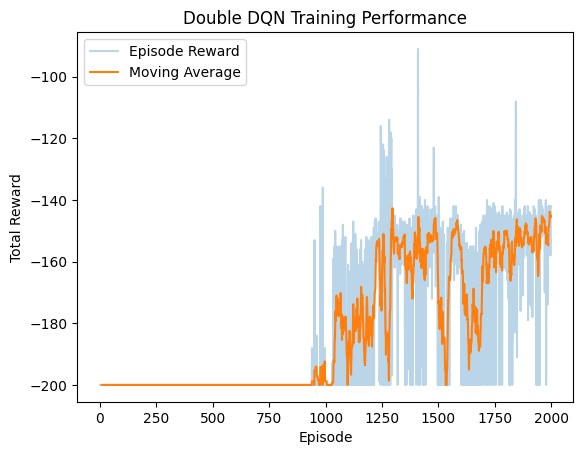

In [13]:
import matplotlib.pyplot as plt

window = 10
moving_avg = np.convolve(
    reward_list,
    np.ones(window)/window,
    mode="valid"
)

plt.plot(reward_list, alpha=0.3, label="Episode Reward")
plt.plot(range(window-1, len(reward_list)), moving_avg, label="Moving Average")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("Double DQN Training Performance")
plt.show()



Double DQN Evaluation

In [14]:
q_net.eval()
eval_reward_list = []
for i in range(10):
    eval_reward, frames = evaluate_and_record(env, q_net, device)
    eval_reward_list.append(eval_reward)

    video_path = f"./results/final_eval_ep{i}.mp4"
    imageio.mimsave(video_path, frames, fps=30)

    print(f"[FINAL EVAL] Episode {i} | Reward: {eval_reward:.2f} | Video saved: {video_path}")


Evaluation Reward: -139.00
[FINAL EVAL] Episode 0 | Reward: -139.00 | Video saved: ./results/final_eval_ep0.mp4


Evaluation Reward: -139.00
[FINAL EVAL] Episode 1 | Reward: -139.00 | Video saved: ./results/final_eval_ep1.mp4


Evaluation Reward: -142.00
[FINAL EVAL] Episode 2 | Reward: -142.00 | Video saved: ./results/final_eval_ep2.mp4


Evaluation Reward: -141.00
[FINAL EVAL] Episode 3 | Reward: -141.00 | Video saved: ./results/final_eval_ep3.mp4


Evaluation Reward: -140.00
[FINAL EVAL] Episode 4 | Reward: -140.00 | Video saved: ./results/final_eval_ep4.mp4


Evaluation Reward: -178.00
[FINAL EVAL] Episode 5 | Reward: -178.00 | Video saved: ./results/final_eval_ep5.mp4


Evaluation Reward: -180.00
[FINAL EVAL] Episode 6 | Reward: -180.00 | Video saved: ./results/final_eval_ep6.mp4


Evaluation Reward: -139.00
[FINAL EVAL] Episode 7 | Reward: -139.00 | Video saved: ./results/final_eval_ep7.mp4


Evaluation Reward: -139.00
[FINAL EVAL] Episode 8 | Reward: -139.00 | Video saved: ./results/final_eval_ep8.mp4


Evaluation Reward: -145.00
[FINAL EVAL] Episode 9 | Reward: -145.00 | Video saved: ./results/final_eval_ep9.mp4


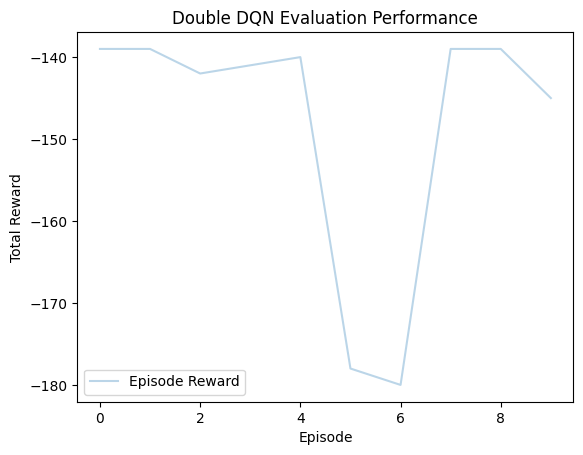

In [15]:
import numpy as np

plt.plot(eval_reward_list, alpha=0.3, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("Double DQN Evaluation Performance")
plt.show()


In [16]:
!zip -r results.zip results
from google.colab import files
files.download("results.zip")

  adding: results/ (stored 0%)
  adding: results/eval_ep1500.mp4 (deflated 40%)
  adding: results/final_eval_ep1.mp4 (deflated 7%)
  adding: results/eval_ep300.mp4 (deflated 12%)
  adding: results/eval_ep900.mp4 (deflated 14%)
  adding: results/eval_ep500.mp4 (deflated 16%)
  adding: results/eval_ep100.mp4 (deflated 17%)
  adding: results/final_eval_ep3.mp4 (deflated 8%)
  adding: results/eval_ep1400.mp4 (deflated 8%)
  adding: results/eval_ep1600.mp4 (deflated 8%)
  adding: results/eval_ep600.mp4 (deflated 27%)
  adding: results/eval_ep0.mp4 (deflated 11%)
  adding: results/eval_ep1000.mp4 (deflated 12%)
  adding: results/final_eval_ep8.mp4 (deflated 7%)
  adding: results/eval_ep200.mp4 (deflated 23%)
  adding: results/final_eval_ep0.mp4 (deflated 7%)
  adding: results/final_eval_ep2.mp4 (deflated 7%)
  adding: results/eval_ep1200.mp4 (deflated 7%)
  adding: results/eval_ep1800.mp4 (deflated 7%)
  adding: results/final_eval_ep9.mp4 (deflated 7%)
  adding: results/eval_ep700.mp4 (defla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>